# <div style="text-align:center"> <span style="font-family:Courier;"> IA Notebook # 2 - Ataques Adversarios </span></div>
## <div style="text-align:center"> <span style="font-family:Courier;"> DOTCSV </span> </div>

In [1]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions #Importando modelo entrenado
from keras import backend as K

In [3]:
iv3 = InceptionV3() #Cargando el modelo

In [4]:
print(iv3.summary()) #Muestras las capas

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [5]:
from keras.preprocessing import image

In [6]:
#target_size = ajustando tamaño de la imagen para que la red neuronal la reciba
x = image.img_to_array(image.load_img('./resources/beagle.jpg', target_size = (299, 299))) #Cargando imagen como un tensor (matrix)
print(x.shape) #Alto, Ancho y profundidad de color (RGB (3))
#Reescalando el rango de intensidad de RGB (0-255) a rango (-1,1) para que sea recibida por la red neuronal
x /=255
x -= 0.5
x *=2 
print(x)
#Ajustando dimension por si recibe varias imagenes en este caso solo recibe una (batch)
x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2]) 
print(x.shape)

(299, 299, 3)
[[[ 0.12156868  0.28627455 -0.42745095]
  [ 0.15294123  0.30980396 -0.38823527]
  [ 0.12156868  0.2941177  -0.35686272]
  ...
  [ 0.18431377  0.36470592 -0.3490196 ]
  [ 0.18431377  0.36470592 -0.3490196 ]
  [ 0.1686275   0.34901965 -0.34117645]]

 [[ 0.12941182  0.2941177  -0.41960782]
  [ 0.1686275   0.33333337 -0.38039213]
  [ 0.11372554  0.28627455 -0.38039213]
  ...
  [ 0.20784318  0.38823533 -0.31764704]
  [ 0.1686275   0.34901965 -0.35686272]
  [ 0.1686275   0.34901965 -0.34117645]]

 [[ 0.14509809  0.30980396 -0.40392154]
  [ 0.16078436  0.32549024 -0.38823527]
  [ 0.11372554  0.2941177  -0.41176468]
  ...
  [ 0.1686275   0.34901965 -0.34117645]
  [ 0.1686275   0.34901965 -0.35686272]
  [ 0.20784318  0.36470592 -0.30196077]]

 ...

 [[-0.09019607  0.10588241 -0.40392154]
  [-0.01176471  0.18431377 -0.3333333 ]
  [-0.19999999  0.00392163 -0.5686275 ]
  ...
  [-0.01960784  0.17647064 -0.4588235 ]
  [ 0.30196083  0.39607847 -0.16862744]
  [ 0.03529418  0.22352946 -0.

In [7]:
y = iv3.predict(x) #Resultado que ha predicho

In [8]:
print(y.shape) # Para cada una de las clases que puede ser esa imagen se obtiene una probabilidad

(1, 1000)


In [9]:
#Mapea las probabilidades con el nombre real de la clase
decode_predictions(y) #Beagle con 78% de probabilidad

[[('n02088364', 'beagle', 0.7862946),
  ('n02089867', 'Walker_hound', 0.046672657),
  ('n02089973', 'English_foxhound', 0.045519914),
  ('n02088238', 'basset', 0.010973066),
  ('n02088632', 'bluetick', 0.0026494276)]]

In [10]:
x2 = image.img_to_array(image.load_img('./resources/clock.jpg', target_size = (299, 299)))
x2 /= 255
x2 -= 0.5
x2 *= 2
x2 = x2.reshape(1, x2.shape[0], x2.shape[1], x2.shape[2])
print(x2.shape)

(1, 299, 299, 3)


In [11]:
y2 = iv3.predict(x2)
decode_predictions(y2) #Reloj de pared con 57% de probabilidades

[[('n04548280', 'wall_clock', 0.57598895),
  ('n02708093', 'analog_clock', 0.25894228),
  ('n02794156', 'barometer', 0.014555166),
  ('n03196217', 'digital_clock', 0.0012279217),
  ('n02825657', 'bell_cote', 0.0010938346)]]

### <center> Ataque adversario </center>

In [12]:
#Realizando proceso de optimización sobre la imagen de entrada para confundir a la imagen y asi maximizar el error
#Redefinir el grafo de la red neural
#Extraemos primer capa, punto de entrada y ultima capa, punto de salida
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output
print(inp_layer)
print(out_layer)

Tensor("input_1:0", shape=(None, 299, 299, 3), dtype=float32)
Tensor("predictions/Softmax:0", shape=(None, 1000), dtype=float32)


In [13]:
targe_class = 951 #Clase de un limon
#Funcion de coste (Determina el error) resultado de la probabilidad de la clase 951 a ser maximizada
loss = out_layer[0, targe_class]
#Usando gradiente sobre la variable de entrada, calcula el grafo de gradientes entre input y la función de coste
grad = K.gradients(loss, inp_layer)[0] #Hace referencia a calcular el gradiente entre el error y la entrada donde dice en que
#proporcion variar los pixeles 

In [14]:
#Funcion a ejecutar iterativamente para computar operación del gradiente
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss]) #Suministra valores de entrada y resultados esperados

adv = np.copy(x)

cost = 0.0

while cost < 0.95: #95%
    gr, cost = optimize_gradient([adv, 0]) #K.learning_phase en 0 estamos en modo de prueba
    
    adv += gr #Sumamos pixeles modificados
    adv = np.clip(adv, -1, 1 )
    print('Target cost:', cost)

Target cost: 0.001197865
Target cost: 0.0012585553
Target cost: 0.0013231213
Target cost: 0.0013919757
Target cost: 0.0014644222
Target cost: 0.0015407118
Target cost: 0.0016211928
Target cost: 0.0017072818
Target cost: 0.0018020911
Target cost: 0.0019047583
Target cost: 0.0020154894
Target cost: 0.0021335888
Target cost: 0.0022614426
Target cost: 0.0024031517
Target cost: 0.0025597694
Target cost: 0.0027340415
Target cost: 0.0029235356
Target cost: 0.0031338683
Target cost: 0.0033667455
Target cost: 0.0036267582
Target cost: 0.0039233514
Target cost: 0.004268073
Target cost: 0.0046623754
Target cost: 0.005128843
Target cost: 0.005701476
Target cost: 0.006398635
Target cost: 0.0071993484
Target cost: 0.008145003
Target cost: 0.009243146
Target cost: 0.01050959
Target cost: 0.012128351
Target cost: 0.014178958
Target cost: 0.017030956
Target cost: 0.02100811
Target cost: 0.026405454
Target cost: 0.03414332
Target cost: 0.04551478
Target cost: 0.05932553
Target cost: 0.08947762
Target co

In [15]:
adv /=2
adv += 0.5
adv *= 255

<function matplotlib.pyplot.show(*args, **kw)>

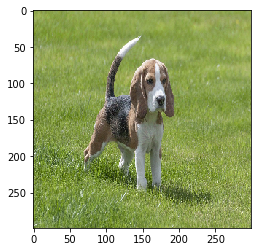

In [16]:
plt.imshow(adv[0].astype(np.uint8))
plt.show

In [17]:
#Ahora probamos sin extralimitando valores para que ocultar cambios en la imagen
#np.clip?

optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss]) 

adv2 = np.copy(x)

cost = 0.0

#perturbacion (cambios en la imagen)

pert = 0.01
max_pert = x + pert
min_pert = x - pert

while cost < 0.95: #95%
    gr, cost = optimize_gradient([adv2, 0]) 
    
    adv2 += gr 
    
    #Satura los valores mayores y menores
    adv2 = np.clip(adv2, min_pert, max_pert)
    adv2 = np.clip(adv2, -1, 1)
    
    print('Target cost:', cost)

modified_img = np.copy(adv2)

Target cost: 0.001197865
Target cost: 0.0012585553
Target cost: 0.0013231213
Target cost: 0.0013919757
Target cost: 0.0014644222
Target cost: 0.0015407118
Target cost: 0.0016211928
Target cost: 0.0017072818
Target cost: 0.0018020911
Target cost: 0.0019047583
Target cost: 0.0020154894
Target cost: 0.0021335888
Target cost: 0.0022614426
Target cost: 0.0024031517
Target cost: 0.0025597694
Target cost: 0.0027340415
Target cost: 0.0029235356
Target cost: 0.0031338683
Target cost: 0.0033667455
Target cost: 0.0036267582
Target cost: 0.0039233514
Target cost: 0.004268073
Target cost: 0.0046623754
Target cost: 0.005128843
Target cost: 0.005701476
Target cost: 0.006398635
Target cost: 0.007199008
Target cost: 0.008142482
Target cost: 0.009235805
Target cost: 0.0104880305
Target cost: 0.012129459
Target cost: 0.014224184
Target cost: 0.017005969
Target cost: 0.020986289
Target cost: 0.026716439
Target cost: 0.03419996
Target cost: 0.04391707
Target cost: 0.058484282
Target cost: 0.0795126
Target 

In [18]:
adv2 /=2
adv2 += 0.5
adv2 *= 255

<function matplotlib.pyplot.show(*args, **kw)>

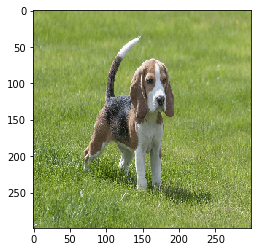

In [19]:
plt.imshow(adv2[0].astype(np.uint8))
plt.show

In [20]:
from PIL import Image
imageS = Image.fromarray(adv[0].astype(np.uint8))
imageS.save('./resources/modified_img.png')

In [21]:
x3 = image.img_to_array(image.load_img('./resources/modified_img.png', target_size = (299, 299)))
x3 /=255
x3 -= 0.5
x3 *=2 
x3 = x3.reshape(1, x3.shape[0], x3.shape[1], x3.shape[2]) 
y3 = iv3.predict(x3)
decode_predictions(y3)

[[('n07749582', 'lemon', 0.9961039),
  ('n02088364', 'beagle', 0.00064120535),
  ('n02102177', 'Welsh_springer_spaniel', 9.099084e-05),
  ('n09229709', 'bubble', 8.592988e-05),
  ('n02102040', 'English_springer', 8.27105e-05)]]